In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
import numpy as np
import scipy.io as spio
import os
from os.path import dirname, join as pjoin
from numpy import array
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from collections import Counter
import seaborn as sns
import glob
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score
from IPython.display import clear_output

In [2]:
mat_path = pjoin('../../ml/NDTPhase2/data','data.mat')
mat = spio.loadmat(mat_path)

In [3]:
cell_data = mat['data']
cell_data.shape

(256, 320, 250)

In [4]:
dt = np.transpose(cell_data)
dt.shape

(250, 320, 256)

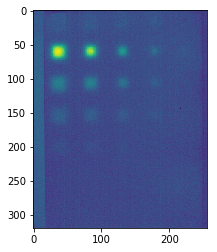

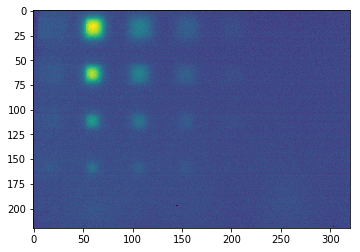

In [5]:
img1 = dt[100]
plt.imshow(img1)
plt.show()
img2 = np.transpose(img1)
plt.imshow(img2[20:240])
plt.show()

In [6]:
def remove_edges(data):
    data_tr2 = np.zeros((250,256,320))
    data_tr3 = np.zeros((250,220,320))
    for i in range(0,250):
        data_tr = np.transpose(data)
        data_tr2[i] = np.transpose(data_tr[i])
        data_tr3[i] = data_tr2[i][20:240]
    return data_tr3    

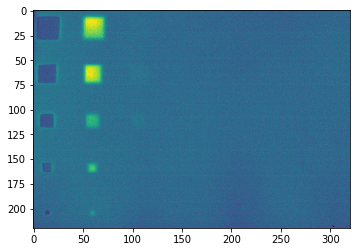

In [7]:
d = remove_edges(cell_data)
plt.imshow(d[10]);

In [8]:
def non_defected_region_points(data):
    nd_points = []
    im = data[10]
    for i in range(0,220):
        for j in range(0,320):
            if(im[i][j]<1.2 and j<40 and j>34):
                nd_points.append([(i,j), 0])
                im[i,j] = 0
    print(len(nd_points))
    return nd_points

1100


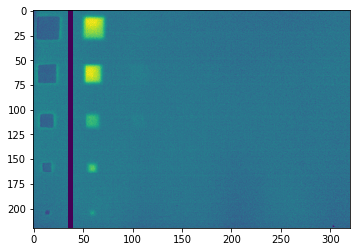

In [9]:
train0 = non_defected_region_points(d)
plt.imshow(d[10])
d = remove_edges(cell_data)

In [10]:
def defected_region_points_fixed(data, defect_index, irange, jrange, time_step=10, highlight=0.7):
    d_points = []
    im = data[time_step]
    count = 0
    for k in range(len(irange)):
        
        irange_, jrange_ = irange[k], jrange[k]
        for i in range(irange_[0]-20, irange_[1]-20):
            for j in range(jrange_[0], jrange_[1]):
                d_points.append([(i,j), defect_index[count]])
                im[i][j] = highlight
        count += 1
    print(len(d_points))
    return d_points

1140


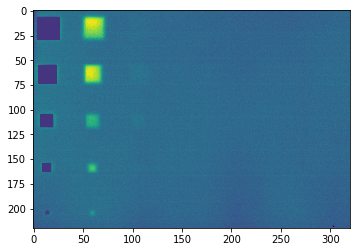

In [11]:
time_step = 10
train1 = defected_region_points_fixed(d, defect_index=[1,2,3,4], irange=[[27,50],[76,95],[125,138],[174,183]], jrange=[[4,27],[5,24],[7, 20],[9,18]], time_step=time_step, highlight=0.5)
plt.imshow(d[time_step])
d = remove_edges(cell_data)

1140


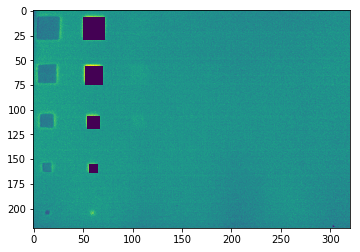

In [12]:
time_step = 10
train2 = defected_region_points_fixed(d, defect_index=[5,6,7,8,5,6,7], irange=[[27,50],[77,96],[127,140],[175,184]], jrange=[[50,73],[52,71],[55, 68],[57,66]], time_step=time_step, highlight=0)
plt.imshow(d[time_step])
d = remove_edges(cell_data)

1347


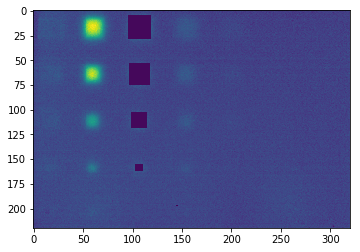

In [13]:
time_step = 80
train3 = defected_region_points_fixed(d, defect_index=[9,10,11,12], irange=[[25,49],[73,96],[123,139],[175,182]], jrange=[[96,119],[97,118],[99,115],[103,111]], time_step=time_step, highlight=0)
plt.imshow(d[time_step])
d = remove_edges(cell_data)

1071


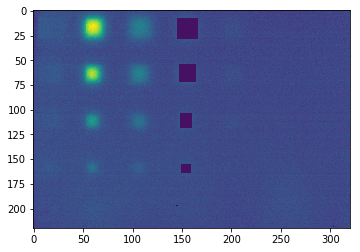

In [14]:
time_step = 100
train4 = defected_region_points_fixed(d, defect_index=[13,14,15,16], irange=[[28,49],[75,93],[124,139],[175,184]], jrange=[[145,167],[147,165],[148,161],[149,159]], time_step=time_step, highlight=0)
plt.imshow(d[time_step])
d = remove_edges(cell_data)

1129


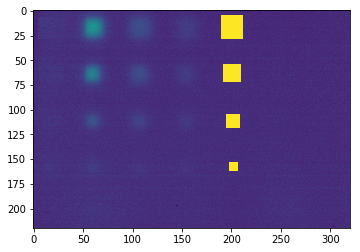

In [15]:
time_step = 150
train5 = defected_region_points_fixed(d, defect_index=[17,18,19,20], irange=[[25,49],[75,93],[125,139],[173,182]], jrange=[[190,212],[192,210],[195,209],[198,207]], time_step=150, highlight=3)
plt.imshow(d[time_step])
d = remove_edges(cell_data)

In [19]:
mat_path2 = pjoin('../../ml/NDTPhase2/data','Square Sample 2.mat')
mat2 = spio.loadmat(mat_path2)
mat2.keys()
cell_data2 = mat2['I']
cell_data2.shape
cell_data3 = np.transpose(cell_data2)
cell_data3.shape

(200, 320, 256)

In [20]:
def remove_edges2(data):
    data_tr = np.zeros((200,256,320))
    data_tr3 = np.zeros((200,220,320))
    for i in range(0,200):
        data_tr[i] = np.transpose(data[i])
        data_tr3[i] = data_tr[i][20:240]

    return data_tr3    
cell_data4 = remove_edges2(cell_data3)
cell_data4.shape

(200, 220, 320)

1100


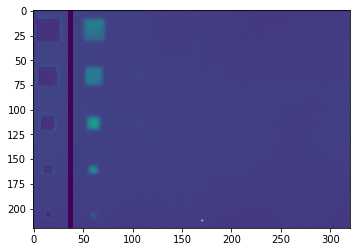

In [21]:
#non defected strip between 1st and 2nd coloumn 
def non_defected_region_points2(data):
    nd_points = []
    im = data[10]
    for i in range(0,220):
        for j in range(0, 320):
            if(im[i][j]<1.2 and j<40 and j>34):
                nd_points.append([(i,j), 0])
                im[i][j] = 0
    print(len(nd_points))
    return nd_points
test0 = non_defected_region_points2(cell_data4)
img3 = cell_data4[10]
plt.imshow(img3)
plt.show()
cell_data4 = remove_edges2(cell_data3)

1140


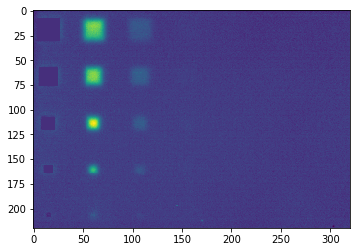

In [22]:
time_step = 30
test1 = defected_region_points_fixed(cell_data4, defect_index=[1,2,3,4], irange=[[28,51],[78,97],[128,141],[176,185]], jrange=[[4,27],[6,25],[9, 22],[11,20]], time_step=time_step, highlight=0.5)
img3 = cell_data4[time_step]
plt.imshow(img3)
plt.show()
cell_data4 = remove_edges2(cell_data3)

1140


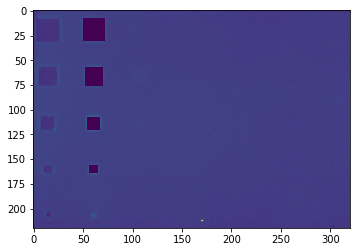

In [23]:
time_step = 10
test2 = defected_region_points_fixed(cell_data4, defect_index=[5,6,7,8], irange=[[28,51],[78,97],[128,141],[176,185]], jrange=[[50,73],[52,71],[55, 68],[57,66]], time_step=time_step, highlight=0)
img3 = cell_data4[time_step]
plt.imshow(img3)
plt.show()
cell_data4 = remove_edges2(cell_data3)

1103


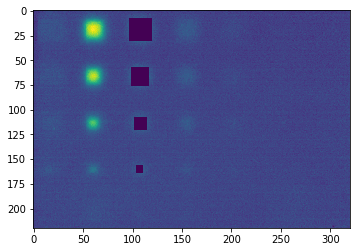

In [24]:
test3 = defected_region_points_fixed(cell_data4, defect_index=[9,10,11,12], irange=[[28,51],[78,97],[128,141],[176,185]], jrange=[[97,120],[99,117],[102,115],[104,111]], time_step=100, highlight=0)
img3 = cell_data4[100]
plt.imshow(img3)
plt.show()
cell_data4 = remove_edges2(cell_data3)

1004


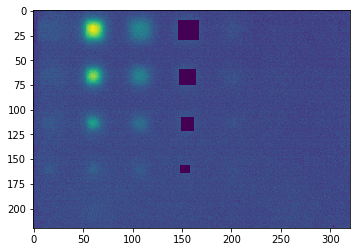

In [25]:
test4 = defected_region_points_fixed(cell_data4, defect_index=[13,14,15,16], irange=[[30,50],[80,96],[128,142],[176,184]], jrange=[[146,168],[147,165],[149,163],[148,158]], time_step=150, highlight=0)
img3 = cell_data4[150]
plt.imshow(img3)
plt.show()
cell_data4 = remove_edges2(cell_data3)

1093


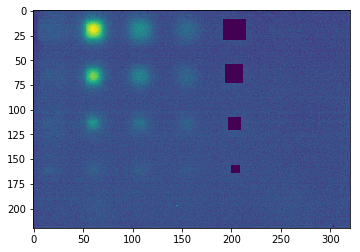

In [26]:
time_step = 180
test5 = defected_region_points_fixed(cell_data4, defect_index=[17,18,19,20], irange=[[29,50],[74,94],[128,141],[176,185]], jrange=[[192,215],[194,212],[197,210],[200,209]], time_step=time_step, highlight=0)
img3 = cell_data4[time_step]
plt.imshow(img3)
plt.show()

In [27]:
def get_defected_data(d,nd_points,d_points):
    data = []
    target = []
    
    for val in range(len(d_points)):
        d_p = d_points[val]
        class_ = classes[val+1]
        for (i,j), idx in d_p:
            d1 = []
            for k in range(200):
                im = d[k]
                v = im[i][j]
                d1.append(v)
            data.append(d1)      
            target.append([class_])
    
    for (i,j), idx in nd_points:
        d1 = []
        for k in range(200):
            im = d[k]
            v = im[i][j]
            d1.append(v)
        data.append(d1)
        target.append([0])
    return data,target

In [28]:
classes = [0, 1, 2, 3, 4, 5]
data_train,target_train = get_defected_data(d, train0, d_points=[train1, train2, train3, train4, train5])
data_test,target_test = get_defected_data(cell_data4, test0, d_points=[test1, test2, test3, test4, test5])

data_train, data_test = torch.from_numpy(np.array(data_train)), torch.from_numpy(np.array(data_test))
target_train, target_test = torch.from_numpy(np.array(target_train)), torch.from_numpy(np.array(target_test))
np.array(data_train).shape,np.array(target_train).shape, np.array(data_test).shape,np.array(target_test).shape

((6927, 200), (6927, 1), (6580, 200), (6580, 1))

In [54]:
class Args:
    def __init__(self):
        self.cuda = True
        self.seed = 1
        self.epochs = 30
        self.lr = 0.005
        self.input = 200
        self.num_layers = 1
        self.hidden = 512
        self.num_classes = 6
args = Args()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [37]:
class LSTM(nn.Module):
    def __init__(self, 
                 hidden=args.hidden, 
                 num_layers=args.num_layers, 
                 input_size=args.input, 
                 num_classes=args.num_classes):
        super(LSTM,self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden, num_classes)
        
    def forward(self,x):
        r_in = x.view(x.shape[0], 1, x.shape[1])
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        return F.log_softmax(r_out2, dim=1)

In [38]:
train_dataset = TensorDataset(data_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = TensorDataset(data_test, target_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [39]:
def iterator(model, epoch, loader=train_loader, mode='train', num_classes=6, norm=None, scheduler=False):
    e = []
    l = 0
    correct = 0
    class_correct = [0]*args.num_classes
    class_count = [0]*args.num_classes
    class_accuracy = [0]*args.num_classes
    loss_fn = F.nll_loss
    if scheduler != 0:
        scheduler_ = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler, gamma=0.1)
    if mode=='test':
        model.eval()
    else:
        model.train()
    for data, target in tqdm(loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        target = target.long()
        target = torch.squeeze(target, dim=1)
        loss = loss_fn(output, target)
        l += loss.item() 
        
        if mode=='train':
            optimizer.zero_grad()
            loss.backward()
            if norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=norm)
            optimizer.step()
            if scheduler != 0:
                scheduler_.step()

        softmax_output = torch.exp(output)
        top_p, top_class = softmax_output.topk(1, dim=1)
        for idx, top in enumerate(top_class):
            class_count[target[idx]] += 1
            if top == target[idx]:
                class_correct[target[idx]] += 1
        equals = top_class == target.view(*top_class.shape)
        correct += torch.mean(equals.type(torch.FloatTensor)).item()
        
    for idx in range(len(class_correct)):
        class_accuracy[idx] = class_correct[idx]/class_count[idx]
    return l/len(loader), correct/len(loader), class_accuracy

In [57]:
def plots(training_loss, test_loss,train_, test_, train, test, save=False, idx=None, info_=None):
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    all_fig = fig.add_gridspec(1, 2, hspace=0.2)
    loss_fig = all_fig[0].subgridspec(1, 1)
    acc_fig = all_fig[1].subgridspec(2, 3)

    ax1 = fig.add_subplot(loss_fig[0, 0])
    ax2 = fig.add_subplot(acc_fig[0, 0])
    ax3 = fig.add_subplot(acc_fig[0, 1])
    ax4 = fig.add_subplot(acc_fig[0, 2])
    ax5 = fig.add_subplot(acc_fig[1, 0])
    ax6 = fig.add_subplot(acc_fig[1, 1])
    ax7 = fig.add_subplot(acc_fig[1, 2])

    ax1.plot(training_loss, 'tab:orange', label='train')
    ax1.plot(test_loss, label='test')
    ax1.legend()
    ax1.set_title('Loss')
    ax2.plot(train_, 'tab:orange', label='train')
    ax2.plot(test_)
    ax2.set_title('Total accuracy')
    ax3.plot(train[1], 'tab:orange', label='train')
    ax3.plot(test[1])
    ax3.set_title('defect 1')
    ax4.plot(train[2], 'tab:orange', label='train')
    ax4.plot(test[2])
    ax4.set_title('defect 2')
    ax5.plot(train[3], 'tab:orange', label='train')
    ax5.plot(test[3])
    ax5.set_title('defect 3')
    ax6.plot(train[4], 'tab:orange', label='train')
    ax6.plot(test[4])
    ax6.set_title('defect 4')
    ax7.plot(train[5], 'tab:orange', label='train')
    ax7.plot(test[5])
    ax7.set_title('defect 5')
    plt.show()
    if save!= False:
        fig.savefig("{}/plot{}.jpeg".format(save,idx))

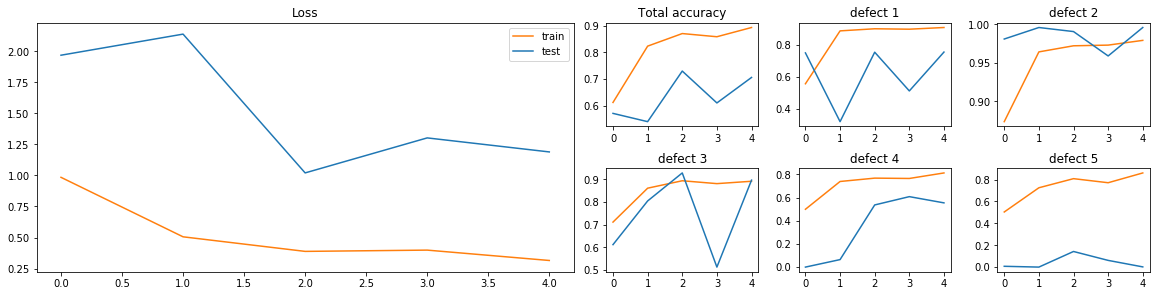

Before Hyperparameter tuning:

max accuracy 0.73% occured at epoch 3


In [63]:
best_acc = 0
final_values = []

model = LSTM().double()
for name, module in model.named_children():
    module.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.95, 0.999))

if args.cuda: 
    model.cuda()
training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []
class_accuracy_train, class_accuracy_test = [[],[],[],[],[],[]], [[],[],[],[],[],[]]

for epoch in range(0, 5):
    loss_, acc_, class_acc_ = iterator(model, epoch)
    training_loss.append(loss_)
    training_accuracy.append(acc_)
    for i in range(len(class_acc_)):
        class_accuracy_train[i].append(class_acc_[i])
    loss_, acc_, class_acc_ = iterator(model, epoch, mode='test', loader=test_loader)
    test_loss.append(loss_)
    test_accuracy.append(acc_)
    if epoch > 5 and test_loss[-5:] == sorted(test_loss[-5:]):
            break
    for i in range(len(class_acc_)):
        class_accuracy_test[i].append(class_acc_[i])
    clear_output()
    if test_accuracy[epoch]>=best_acc:
        best_acc = test_accuracy[epoch]
#         torch.save(model.state_dict(), '../models/6class_best_model.pth')

    plots(training_loss, test_loss, training_accuracy, test_accuracy, 
          class_accuracy_train, class_accuracy_test)
print('Before Hyperparameter tuning:\n')
print('max accuracy {0:.2f}% occured at epoch {1}'
      .format(max(test_accuracy), np.argmax(np.array(test_accuracy)) + 1))


Single defect accuracy before hyperparameter tuning:

0.83	0.99	0.87	0.81	0.0	

0.7	0.99	0.96	0.64	0.0	

0.78	1.0	0.97	0.09	0.0	

0.48	1.0	0.57	0.0	0.0	

1.0


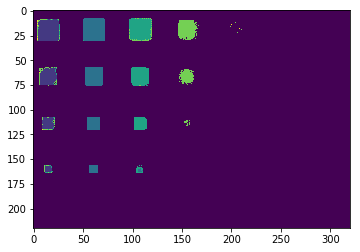

In [64]:
def mark_spots(model=model, loader=test_loader, points_=[test1, test2, test3, test4, test5, test0], bs=32):
    model.eval()
    intensity = [1, 5, 10, 15, 20, 25]
    bs = bs
    img = np.ones((220,320))
    defect_acc = [0]*21
    defect_count = [0]*21
    points = []
    for i in range(len(points_)):
        points.extend(points_[i])
    loop_count = 0
    for data, target in tqdm(loader):
        if args.cuda:
            data = data.cuda()
        output = model(data)        
        softmax_output = torch.exp(output)
        top_p, top_class = softmax_output.topk(1, dim=1)
        current_points = points[loop_count*bs:(loop_count+1)*bs]
        for idx in range(len(output)):
            
            class_ = top_class[idx].item()
            point, defect = current_points[idx]
            img[point] = intensity[class_]
            defect_count[defect] += 1
            if defect%4 != 0:
                defect_ = int(defect/4)+1
            else:
                defect_ = int(defect/4)
            if defect_ == top_class[idx].item():
                defect_acc[defect] += 1
        loop_count += 1
    plt.imshow(img)
    acc = [round(i / j,2) for i, j in zip(defect_acc, defect_count)] 
    a = acc[1:]
    print('Single defect accuracy before hyperparameter tuning:\n')
    for i in range(4):
        for j in range(5):
            print(a[j*4+i], end='\t')
        print('\n')
    print(acc[0])
    return acc
        
acc = mark_spots(model, test_loader)